# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [176]:
# code if ran on google colab
#from google.colab import drive
#drive.mount('/content/drive')

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [177]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    MaxPool2D,
    GlobalMaxPooling2D,
    BatchNormalization
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
import itertools

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use ImageNet
from tensorflow.keras.applications import VGG16, ResNet50
from keras.preprocessing.image import img_to_array, load_img


## Loading the dataset

Must load independent data sets containing the images and associated labels.

In [178]:
# For working on local machine
orig_images = np.load('images.npy')
labels = pd.read_csv('Labels.csv')

In [179]:
# For working on Google Colab
#orig_images = np.load('/content/drive/MyDrive/UT/Project 5/images.npy')
#labels = pd.read_csv('/content/drive/MyDrive/UT/Project 5/Labels.csv')

In [180]:
#creating copy to make changes to. Will reference orig_images for comparison
images = orig_images.copy()

## Data Overview

### Understand the shape of the dataset

In [181]:
print("images shape: ", images.shape)
print("labels shape: ", labels.shape)

images shape:  (4750, 128, 128, 3)
labels shape:  (4750, 1)


**Oberservations**

From the data, we can see that the both the images and labels contain 4,750 rows, which is expected as the labels must be associated with the images. Further, the size of the images are 128x128 and contain three channels associated with Red, Green, Blue.

## Exploratory Data Analysis

In [235]:
def plot_images(images, labels):
    categories = np.unique(labels['Label'])
    num_classes = len(categories)  
    rows = 3  
    cols = 4 
    assert rows * cols >= num_classes, "The grid is too small to display one image per label."
    
    fig = plt.figure(figsize=(10, 8))  
    
    # Loop over the number of unique classes
    for i, category in enumerate(categories):
        indices = np.where(labels['Label'] == category)[0]
        image_index = indices[0]
        
        ax = fig.add_subplot(rows, cols, i + 1) 
        ax.imshow(images[image_index]) 
        ax.set_title(category)  
        ax.axis('off')  
    
    plt.tight_layout()  
    plt.show()

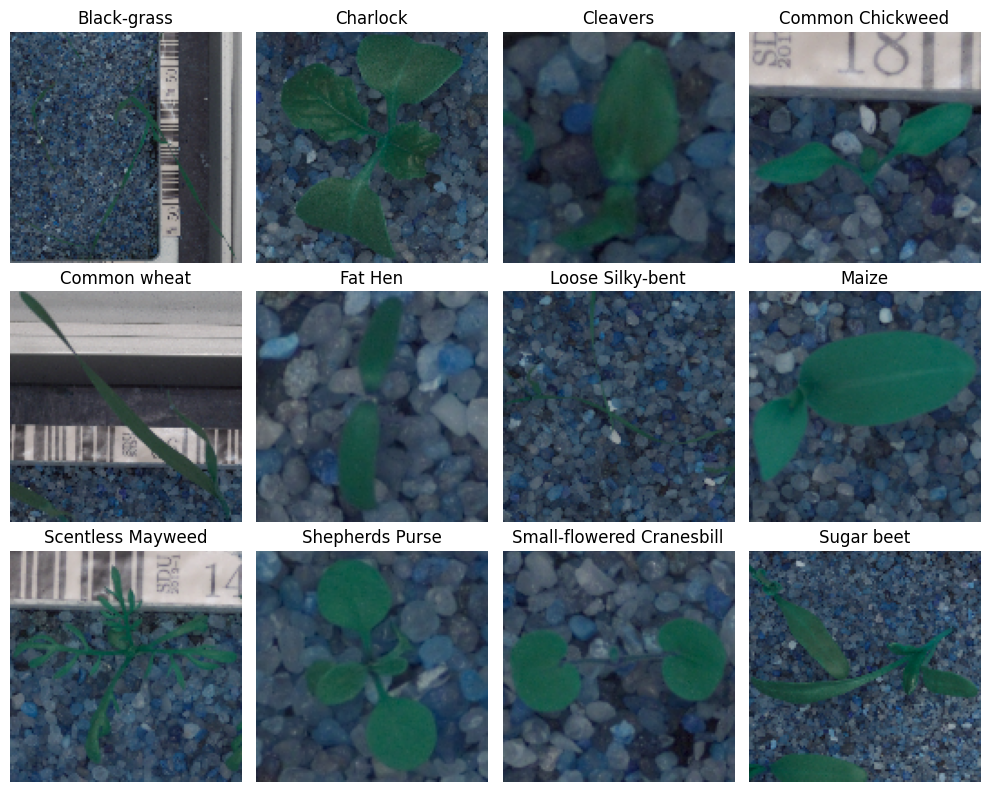

In [237]:
plot_images(orig_images,labels)

**Observations**

* Using the `plot_images` function, we're looking at a random assortment of images of the plant seedlings to familiarize ourselves with the dataset. Each shown are positioned center, or near center, and are 128 x 128 pixels as shown by the graph markers.

* The images consist of small seedlings with various shades of green, with a backdrop with more blueish hues. Overall the images appear dark.

* not all images have the same rock backdrop, as some appear to have a wood backdrop.
* We can see some off the plant seediling do appear similar, or may not have enough within the image to discern. For example, Cleavers and Maize appear similar from their images. 

Number of Loose Silky-bent images is: 654
Number of Common Chickweed images is: 611
Number of Scentless Mayweed images is: 516
Number of Small-flowered Cranesbill images is: 496
Number of Fat Hen images is: 475
Number of Charlock images is: 390
Number of Sugar beet images is: 385
Number of Cleavers images is: 287
Number of Black-grass images is: 263
Number of Shepherds Purse images is: 231
Number of Common wheat images is: 221
Number of Maize images is: 221


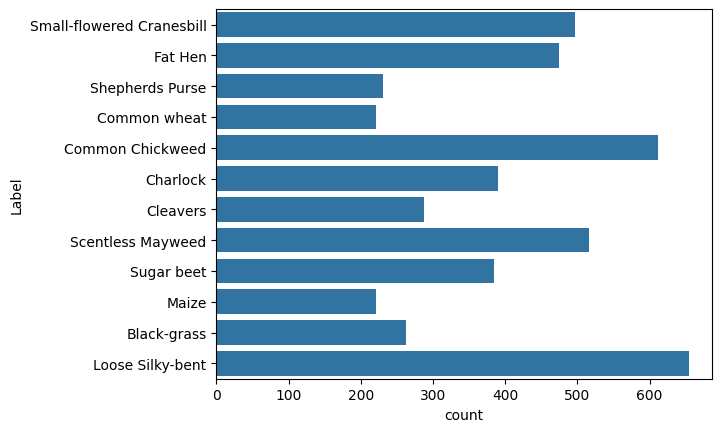

In [184]:
sns.countplot(labels['Label']);

unique_labels = np.unique(labels['Label'])
label_counts = {Label: len(images[labels['Label'] == Label]) for Label in unique_labels}
sorted_label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

for Label, count in sorted_label_counts.items():
    print("Number of {} images is: {}".format(Label, count))

**Observations**
There is somewhat of an imbalance with both `Loose Silky-bent` has nearly three times the amount of data than the bottom `Maize` images.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [185]:
for i in range(len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [186]:
def resize_images(img):
    img = np.array(img).astype(np.uint8)
    res = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    return res

In [187]:
dec_images = [resize_images(img) for img in images]

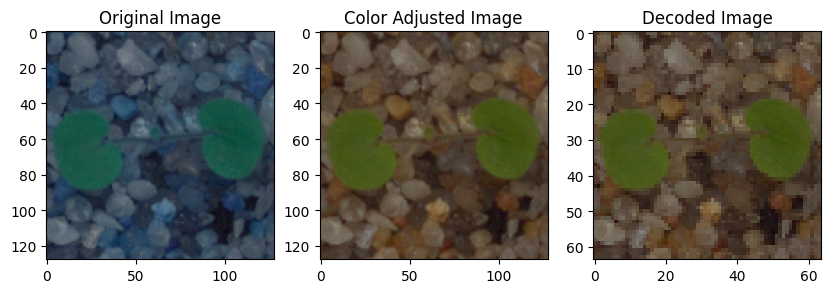

In [188]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_images[0])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(images[0])
plt.title('Color Adjusted Image')

plt.subplot(1, 3, 3)
plt.imshow(dec_images[0])
plt.title('Decoded Image')

plt.show()

**Observations**

We can see between the original and the decoded image that there are various changes made:
* The color difference removed a more blue-ish hue and darker green to lighter more saturated colors.
* Reduction of pixel size removes detail, however change appears to show a bit more contrast betwen the background and the plant's leaves
* detail of the actual plant does appear to be lost, as the stem of the plant blends in more with the background

### Data Preparation for Modeling

**Split the dataset of Decoded Images**

In [189]:
X_temp, X_val, y_temp, y_val = train_test_split(np.array(dec_images), labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("Training Data Shape (X; y):", X_train.shape,"; ", y_train.shape)
print()
print("Validation Data Shape (X; y):", X_val.shape,"; ", y_val.shape)
print()
print("Testing Data Shape (X; y):", X_test.shape, "; ", y_test.shape)

Training Data Shape (X; y): (2850, 64, 64, 3) ;  (2850, 1)

Validation Data Shape (X; y): (950, 64, 64, 3) ;  (950, 1)

Testing Data Shape (X; y): (950, 64, 64, 3) ;  (950, 1)


**Obervations**

Data is split between Train, Validation, and Test set. We'll utilize the validation set against the Train data, and save the Test set to review the performance of the model prior to referencing the final test set for review.

### Encode the target labels

In [190]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

### Data Normalization

In [191]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## Model Building

In [192]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [193]:
model = Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,356 (364.67 KB)

 Trainable params: 93,356 (364.67 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001)

In [195]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [196]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[es])

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.1182 - loss: 2.4611 - val_accuracy: 0.2453 - val_loss: 2.4135
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2398 - loss: 2.2194 - val_accuracy: 0.2747 - val_loss: 2.1142
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2772 - loss: 1.9768 - val_accuracy: 0.3358 - val_loss: 2.0335
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3115 - loss: 1.8785 - val_accuracy: 0.2958 - val_loss: 1.9955
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3251 - loss: 1.8171 - val_accuracy: 0.3863 - val_loss: 1.9379
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3509 - loss: 1.7739 - val_accuracy: 0.3747 - val_loss: 1.8609
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3577 - loss: 1.7526 - val_accuracy: 0.3695 - val_loss: 1.9113
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3728 - loss: 1.7136 - val_accuracy: 0.

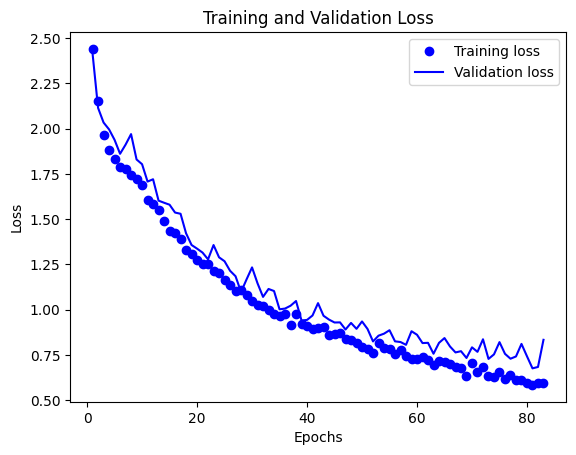

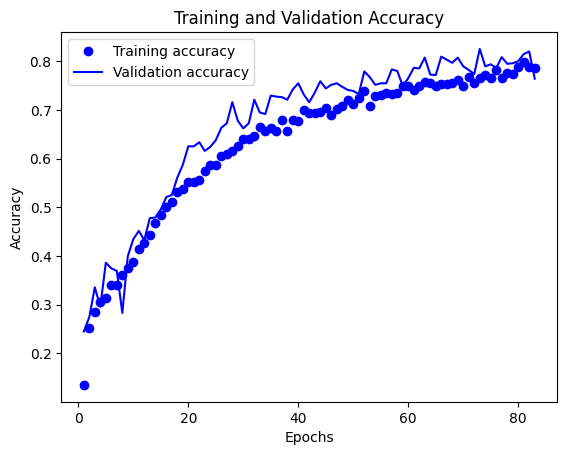

In [197]:
# Assuming you have a `history` object from model training
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [198]:
# Score trained model.
results_df = pd.DataFrame(columns=['Model', 'Test Loss', 'Test Accuracy'])
scores = model.evaluate(X_test, y_test, verbose=1)
new_row = pd.DataFrame([{'Model': 'Built Model', 'Test Loss': scores[0], 'Test Accuracy': scores[1]}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
print(results_df)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7462 - loss: 0.8678
         Model  Test Loss  Test Accuracy
0  Built Model   0.844651       0.747368


#### Using ImageNet to build a model

In [199]:
# defining the model
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


base_model = VGG16(
    weights='imagenet',                                                        # Loads the pre-trained weights of the VGG16 model trained on ImageNet dataset
    include_top=False,                                                         # Excludes the top (fully connected) layers of the VGG16 model
    input_shape=X_train.shape[1:]                                              # Defines the input shape as the shape of the training data
)
base_model.trainable = False                                                   # Freezes the weights of the VGG16 model to prevent further training

ai_model = tf.keras.Sequential()                                            # Creates a sequential model
ai_model.add(base_model)                                                    # Adds the VGG16 base model to the sequential model
ai_model.add(tf.keras.layers.GlobalAveragePooling2D())                      # Adds a global average pooling layer

ai_model.add(tf.keras.layers.Flatten())                                     # Flattens the input for the subsequent fully connected
ai_model.add(tf.keras.layers.Dense(12, activation='softmax'))                # Adds the final fully connected layer with 3 units and softmax activation

ai_model.compile(loss='categorical_crossentropy',                      # Specifies the loss function for trainin
              optimizer=Adam(learning_rate=0.001),                       # Sets the optimizer (Adam) and learning rate
              metrics=['accuracy'])                                                 # Specifies the metrics to evaluate the model's performance
ai_model.summary()

history_ai = ai_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[es])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.1348 - loss: 2.4718 - val_accuracy: 0.2516 - val_loss: 2.2207
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.2937 - loss: 2.1506 - val_accuracy: 0.3358 - val_loss: 2.0734
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.3638 - loss: 2.0062 - val_accuracy: 0.3695 - val_loss: 1.9726
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.4040 - loss: 1.9029 - val_accuracy: 0.4011 - val_loss: 1.8972
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.4330 - loss: 1.8235 - val_accuracy: 0.4253 - val_loss: 1.8377
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.4606 - loss: 1.7594 - val_accuracy: 0.4432 - val_loss: 1.7891
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.4772 - loss: 1.7061 - val_accuracy: 0.4537 - val_loss: 1.7483
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.4892 - loss: 1.6605 - 

In [200]:
# Score trained ai_model.
scores = ai_model.evaluate(X_test, y_test, verbose=1)
new_row = pd.DataFrame([{'Model': 'VGG16', 'Test Loss': scores[0], 'Test Accuracy': scores[1]}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
print(results_df)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4563 - loss: 1.6980
         Model  Test Loss  Test Accuracy
0  Built Model   0.844651       0.747368
1        VGG16   1.684227       0.465263


## Model Performance Improvement

### Further Image Processing

Going to add a masking and some sharpening to the image in order to further discern the plant from the background for improving the training of the model

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [205]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose = 0,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 50
batch_size = 32

In [204]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [206]:
history = model.fit(datagen.flow(X_train,y_train,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7694 - loss: 0.6489 - val_accuracy: 0.8179 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 2/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7500 - loss: 0.7270

2024-06-17 20:32:01.409561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.7270 - val_accuracy: 0.8000 - val_loss: 0.7262 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7661 - loss: 0.6416 - val_accuracy: 0.8168 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 4/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7812 - loss: 0.6633

2024-06-17 20:32:08.430410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.6633 - val_accuracy: 0.8168 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7514 - loss: 0.6642 - val_accuracy: 0.8316 - val_loss: 0.6503 - learning_rate: 5.0000e-04
Epoch 6/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8438 - loss: 0.6449

2024-06-17 20:32:17.196347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8438 - loss: 0.6449 - val_accuracy: 0.8253 - val_loss: 0.6602 - learning_rate: 5.0000e-04
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7744 - loss: 0.6070 - val_accuracy: 0.8284 - val_loss: 0.6673 - learning_rate: 5.0000e-04
Epoch 8/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8125 - loss: 0.4148

2024-06-17 20:32:23.612538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.4148 - val_accuracy: 0.8305 - val_loss: 0.6677 - learning_rate: 5.0000e-04
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8079 - loss: 0.5342 - val_accuracy: 0.8463 - val_loss: 0.6235 - learning_rate: 2.5000e-04
Epoch 10/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8438 - loss: 0.3903

2024-06-17 20:32:29.996300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8438 - loss: 0.3903 - val_accuracy: 0.8453 - val_loss: 0.6221 - learning_rate: 2.5000e-04
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8210 - loss: 0.5093 - val_accuracy: 0.8358 - val_loss: 0.6261 - learning_rate: 2.5000e-04
Epoch 12/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7812 - loss: 0.5882

2024-06-17 20:32:36.366328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.5882 - val_accuracy: 0.8337 - val_loss: 0.6278 - learning_rate: 2.5000e-04
Epoch 13/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8205 - loss: 0.5156 - val_accuracy: 0.8368 - val_loss: 0.6600 - learning_rate: 2.5000e-04
Epoch 14/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9375 - loss: 0.2736

2024-06-17 20:32:42.827427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9375 - loss: 0.2736 - val_accuracy: 0.8368 - val_loss: 0.6564 - learning_rate: 1.2500e-04
Epoch 15/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8084 - loss: 0.5354 - val_accuracy: 0.8516 - val_loss: 0.5986 - learning_rate: 1.2500e-04
Epoch 16/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7812 - loss: 0.5924

2024-06-17 20:32:49.199493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.5924 - val_accuracy: 0.8505 - val_loss: 0.5973 - learning_rate: 1.2500e-04
Epoch 17/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8103 - loss: 0.5118 - val_accuracy: 0.8495 - val_loss: 0.5980 - learning_rate: 1.2500e-04
Epoch 18/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7812 - loss: 0.4041

2024-06-17 20:32:55.677149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.4041 - val_accuracy: 0.8495 - val_loss: 0.5980 - learning_rate: 1.2500e-04
Epoch 19/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8030 - loss: 0.5409 - val_accuracy: 0.8505 - val_loss: 0.5987 - learning_rate: 1.2500e-04
Epoch 20/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.7812 - loss: 0.4712

2024-06-17 20:33:02.019261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 0.4712 - val_accuracy: 0.8505 - val_loss: 0.5995 - learning_rate: 6.2500e-05
Epoch 21/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8124 - loss: 0.4942 - val_accuracy: 0.8526 - val_loss: 0.6019 - learning_rate: 6.2500e-05
Epoch 22/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8750 - loss: 0.3970

2024-06-17 20:33:08.563872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8750 - loss: 0.3970 - val_accuracy: 0.8526 - val_loss: 0.6012 - learning_rate: 6.2500e-05
Epoch 23/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8051 - loss: 0.4900 - val_accuracy: 0.8484 - val_loss: 0.5986 - learning_rate: 3.1250e-05
Epoch 24/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6875 - loss: 0.9598

2024-06-17 20:33:15.111173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.9598 - val_accuracy: 0.8484 - val_loss: 0.5990 - learning_rate: 3.1250e-05
Epoch 25/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8120 - loss: 0.4963 - val_accuracy: 0.8432 - val_loss: 0.5994 - learning_rate: 3.1250e-05
Epoch 26/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8125 - loss: 0.6130

2024-06-17 20:33:21.496058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.6130 - val_accuracy: 0.8432 - val_loss: 0.5996 - learning_rate: 1.5625e-05
Epoch 27/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8159 - loss: 0.4918 - val_accuracy: 0.8484 - val_loss: 0.5991 - learning_rate: 1.5625e-05
Epoch 28/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6875 - loss: 0.6332

2024-06-17 20:33:27.940592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6875 - loss: 0.6332 - val_accuracy: 0.8484 - val_loss: 0.5991 - learning_rate: 1.5625e-05
Epoch 29/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8264 - loss: 0.4975 - val_accuracy: 0.8526 - val_loss: 0.5969 - learning_rate: 1.0000e-05
Epoch 30/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8125 - loss: 0.5151

2024-06-17 20:33:34.299271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8125 - loss: 0.5151 - val_accuracy: 0.8526 - val_loss: 0.5969 - learning_rate: 1.0000e-05
Epoch 31/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8262 - loss: 0.4840 - val_accuracy: 0.8516 - val_loss: 0.5958 - learning_rate: 1.0000e-05
Epoch 32/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.8438 - loss: 0.5714

2024-06-17 20:33:40.762692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8438 - loss: 0.5714 - val_accuracy: 0.8537 - val_loss: 0.5958 - learning_rate: 1.0000e-05
Epoch 33/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8168 - loss: 0.4916 - val_accuracy: 0.8537 - val_loss: 0.5992 - learning_rate: 1.0000e-05
Epoch 34/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7812 - loss: 0.4803

2024-06-17 20:33:47.108265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.4803 - val_accuracy: 0.8526 - val_loss: 0.5992 - learning_rate: 1.0000e-05
Epoch 35/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8245 - loss: 0.4775 - val_accuracy: 0.8484 - val_loss: 0.5957 - learning_rate: 1.0000e-05
Epoch 36/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7188 - loss: 0.7135

2024-06-17 20:33:53.406278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.7135 - val_accuracy: 0.8484 - val_loss: 0.5956 - learning_rate: 1.0000e-05
Epoch 37/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8330 - loss: 0.4942 - val_accuracy: 0.8537 - val_loss: 0.5919 - learning_rate: 1.0000e-05
Epoch 38/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9062 - loss: 0.3508

2024-06-17 20:33:59.786916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.3508 - val_accuracy: 0.8537 - val_loss: 0.5918 - learning_rate: 1.0000e-05
Epoch 39/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8204 - loss: 0.4993 - val_accuracy: 0.8526 - val_loss: 0.5916 - learning_rate: 1.0000e-05
Epoch 40/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7500 - loss: 0.7801

2024-06-17 20:34:06.186324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.7801 - val_accuracy: 0.8526 - val_loss: 0.5918 - learning_rate: 1.0000e-05
Epoch 41/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8308 - loss: 0.4789 - val_accuracy: 0.8516 - val_loss: 0.5943 - learning_rate: 1.0000e-05
Epoch 42/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8750 - loss: 0.4635

2024-06-17 20:34:12.556652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8750 - loss: 0.4635 - val_accuracy: 0.8516 - val_loss: 0.5943 - learning_rate: 1.0000e-05
Epoch 43/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8221 - loss: 0.4918 - val_accuracy: 0.8495 - val_loss: 0.5932 - learning_rate: 1.0000e-05
Epoch 44/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8438 - loss: 0.5079

2024-06-17 20:34:18.910556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8438 - loss: 0.5079 - val_accuracy: 0.8495 - val_loss: 0.5933 - learning_rate: 1.0000e-05
Epoch 45/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8237 - loss: 0.4914 - val_accuracy: 0.8526 - val_loss: 0.5922 - learning_rate: 1.0000e-05
Epoch 46/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7812 - loss: 0.4171

2024-06-17 20:34:25.332405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.4171 - val_accuracy: 0.8526 - val_loss: 0.5921 - learning_rate: 1.0000e-05
Epoch 47/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8287 - loss: 0.4874 - val_accuracy: 0.8526 - val_loss: 0.5953 - learning_rate: 1.0000e-05
Epoch 48/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9062 - loss: 0.3407

2024-06-17 20:34:32.818967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.3407 - val_accuracy: 0.8526 - val_loss: 0.5954 - learning_rate: 1.0000e-05
Epoch 49/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8281 - loss: 0.4761 - val_accuracy: 0.8516 - val_loss: 0.5933 - learning_rate: 1.0000e-05
Epoch 50/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7500 - loss: 0.6012

2024-06-17 20:34:39.363998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.6012 - val_accuracy: 0.8516 - val_loss: 0.5933 - learning_rate: 1.0000e-05


In [207]:
scores = model.evaluate(X_test, y_test, verbose=1)
new_row = pd.DataFrame([{'Model': 'Built Model w Data Aug', 'Test Loss': scores[0], 'Test Accuracy': scores[1]}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
print(results_df)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8316 - loss: 0.5930
                    Model  Test Loss  Test Accuracy
0             Built Model   0.844651       0.747368
1                   VGG16   1.684227       0.465263
2  Built Model w Data Aug   0.575636       0.833684


In [208]:
history = ai_model.fit(datagen.flow(X_train,y_train,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train.shape[0] // batch_size,
                                       validation_data=(X_val,y_val),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4755 - loss: 1.6488 - val_accuracy: 0.4558 - val_loss: 1.6577 - learning_rate: 0.0010
Epoch 2/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4062 - loss: 1.6576

2024-06-17 20:35:15.597205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4062 - loss: 1.6576 - val_accuracy: 0.4579 - val_loss: 1.6586 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.4732 - loss: 1.6641 - val_accuracy: 0.4705 - val_loss: 1.6197 - learning_rate: 0.0010
Epoch 4/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4688 - loss: 1.6006

2024-06-17 20:35:27.716229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4688 - loss: 1.6006 - val_accuracy: 0.4674 - val_loss: 1.6198 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5100 - loss: 1.5950 - val_accuracy: 0.4663 - val_loss: 1.6019 - learning_rate: 0.0010
Epoch 6/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.4062 - loss: 1.7697

2024-06-17 20:35:39.929286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4062 - loss: 1.7697 - val_accuracy: 0.4621 - val_loss: 1.6019 - learning_rate: 0.0010
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4790 - loss: 1.6069 - val_accuracy: 0.4747 - val_loss: 1.5828 - learning_rate: 0.0010
Epoch 8/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6562 - loss: 1.4867

2024-06-17 20:35:52.016063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6562 - loss: 1.4867 - val_accuracy: 0.4758 - val_loss: 1.5819 - learning_rate: 0.0010
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.4907 - loss: 1.5600 - val_accuracy: 0.4632 - val_loss: 1.5711 - learning_rate: 0.0010
Epoch 10/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3750 - loss: 1.8239

2024-06-17 20:36:04.051925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3750 - loss: 1.8239 - val_accuracy: 0.4663 - val_loss: 1.5707 - learning_rate: 0.0010
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5179 - loss: 1.5421 - val_accuracy: 0.4705 - val_loss: 1.5591 - learning_rate: 0.0010
Epoch 12/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4688 - loss: 1.5715

2024-06-17 20:36:16.300950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4688 - loss: 1.5715 - val_accuracy: 0.4716 - val_loss: 1.5588 - learning_rate: 0.0010
Epoch 13/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5284 - loss: 1.5113 - val_accuracy: 0.4789 - val_loss: 1.5415 - learning_rate: 0.0010
Epoch 14/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4688 - loss: 1.5439

2024-06-17 20:36:28.507154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4688 - loss: 1.5439 - val_accuracy: 0.4779 - val_loss: 1.5408 - learning_rate: 0.0010
Epoch 15/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.5063 - loss: 1.5334 - val_accuracy: 0.4958 - val_loss: 1.5322 - learning_rate: 0.0010
Epoch 16/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5000 - loss: 1.4099

2024-06-17 20:36:40.704658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5000 - loss: 1.4099 - val_accuracy: 0.4916 - val_loss: 1.5323 - learning_rate: 0.0010
Epoch 17/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5335 - loss: 1.5000 - val_accuracy: 0.4726 - val_loss: 1.5335 - learning_rate: 0.0010
Epoch 18/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7188 - loss: 1.2233

2024-06-17 20:36:52.716311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7188 - loss: 1.2233 - val_accuracy: 0.4737 - val_loss: 1.5331 - learning_rate: 0.0010
Epoch 19/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5314 - loss: 1.4830 - val_accuracy: 0.4811 - val_loss: 1.5244 - learning_rate: 5.0000e-04
Epoch 20/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.6875 - loss: 1.3562

2024-06-17 20:37:04.986251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6875 - loss: 1.3562 - val_accuracy: 0.4800 - val_loss: 1.5241 - learning_rate: 5.0000e-04
Epoch 21/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.5162 - loss: 1.5034 - val_accuracy: 0.4758 - val_loss: 1.5208 - learning_rate: 5.0000e-04
Epoch 22/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5000 - loss: 1.3428

2024-06-17 20:37:17.174916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5000 - loss: 1.3428 - val_accuracy: 0.4747 - val_loss: 1.5213 - learning_rate: 5.0000e-04
Epoch 23/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5173 - loss: 1.4574 - val_accuracy: 0.4884 - val_loss: 1.5119 - learning_rate: 5.0000e-04
Epoch 24/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4688 - loss: 1.6515

2024-06-17 20:37:29.599808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4688 - loss: 1.6515 - val_accuracy: 0.4884 - val_loss: 1.5114 - learning_rate: 5.0000e-04
Epoch 25/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.5245 - loss: 1.4738 - val_accuracy: 0.4979 - val_loss: 1.5020 - learning_rate: 5.0000e-04
Epoch 26/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5000 - loss: 1.7018

2024-06-17 20:37:41.884341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5000 - loss: 1.7018 - val_accuracy: 0.5011 - val_loss: 1.5024 - learning_rate: 5.0000e-04
Epoch 27/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.5353 - loss: 1.4627 - val_accuracy: 0.4989 - val_loss: 1.4990 - learning_rate: 5.0000e-04
Epoch 28/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5625 - loss: 1.5737

2024-06-17 20:37:54.062944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5625 - loss: 1.5737 - val_accuracy: 0.4979 - val_loss: 1.4993 - learning_rate: 5.0000e-04
Epoch 29/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.5516 - loss: 1.4382 - val_accuracy: 0.4968 - val_loss: 1.4899 - learning_rate: 5.0000e-04
Epoch 30/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6250 - loss: 1.3169

2024-06-17 20:38:08.056018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6250 - loss: 1.3169 - val_accuracy: 0.4968 - val_loss: 1.4895 - learning_rate: 5.0000e-04
Epoch 31/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.5242 - loss: 1.4655 - val_accuracy: 0.4958 - val_loss: 1.4863 - learning_rate: 5.0000e-04
Epoch 32/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.6250 - loss: 1.3212

2024-06-17 20:38:20.431527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6250 - loss: 1.3212 - val_accuracy: 0.4947 - val_loss: 1.4865 - learning_rate: 5.0000e-04
Epoch 33/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5255 - loss: 1.4580 - val_accuracy: 0.4937 - val_loss: 1.4871 - learning_rate: 5.0000e-04
Epoch 34/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5000 - loss: 1.4525

2024-06-17 20:38:32.609410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5000 - loss: 1.4525 - val_accuracy: 0.4926 - val_loss: 1.4870 - learning_rate: 5.0000e-04
Epoch 35/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.5380 - loss: 1.4406 - val_accuracy: 0.5011 - val_loss: 1.4837 - learning_rate: 2.5000e-04
Epoch 36/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5625 - loss: 1.5213

2024-06-17 20:38:45.050833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5625 - loss: 1.5213 - val_accuracy: 0.5021 - val_loss: 1.4837 - learning_rate: 2.5000e-04
Epoch 37/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5347 - loss: 1.4505 - val_accuracy: 0.4989 - val_loss: 1.4818 - learning_rate: 2.5000e-04
Epoch 38/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5625 - loss: 1.4717

2024-06-17 20:38:59.286389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5625 - loss: 1.4717 - val_accuracy: 0.4989 - val_loss: 1.4816 - learning_rate: 2.5000e-04
Epoch 39/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5526 - loss: 1.4267 - val_accuracy: 0.4979 - val_loss: 1.4818 - learning_rate: 2.5000e-04
Epoch 40/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.3125 - loss: 1.6872

2024-06-17 20:39:12.165816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3125 - loss: 1.6872 - val_accuracy: 0.4968 - val_loss: 1.4818 - learning_rate: 2.5000e-04
Epoch 41/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5602 - loss: 1.4154 - val_accuracy: 0.5042 - val_loss: 1.4779 - learning_rate: 2.5000e-04
Epoch 42/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.6250 - loss: 1.3507

2024-06-17 20:39:24.505543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6250 - loss: 1.3507 - val_accuracy: 0.5042 - val_loss: 1.4781 - learning_rate: 2.5000e-04
Epoch 43/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5569 - loss: 1.4227 - val_accuracy: 0.5032 - val_loss: 1.4743 - learning_rate: 2.5000e-04
Epoch 44/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.4375 - loss: 1.6437

2024-06-17 20:39:36.769132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4375 - loss: 1.6437 - val_accuracy: 0.5032 - val_loss: 1.4741 - learning_rate: 2.5000e-04
Epoch 45/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5292 - loss: 1.4432 - val_accuracy: 0.5021 - val_loss: 1.4757 - learning_rate: 2.5000e-04
Epoch 46/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.4688 - loss: 1.5423

2024-06-17 20:39:49.454863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4688 - loss: 1.5423 - val_accuracy: 0.5011 - val_loss: 1.4755 - learning_rate: 2.5000e-04
Epoch 47/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5572 - loss: 1.3988 - val_accuracy: 0.4989 - val_loss: 1.4717 - learning_rate: 2.5000e-04
Epoch 48/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6562 - loss: 1.2393

2024-06-17 20:40:01.736270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6562 - loss: 1.2393 - val_accuracy: 0.4979 - val_loss: 1.4717 - learning_rate: 2.5000e-04
Epoch 49/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.5452 - loss: 1.4145 - val_accuracy: 0.5042 - val_loss: 1.4670 - learning_rate: 2.5000e-04
Epoch 50/50
 1/89 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5000 - loss: 1.3533

2024-06-17 20:40:14.249416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5000 - loss: 1.3533 - val_accuracy: 0.5042 - val_loss: 1.4671 - learning_rate: 2.5000e-04


In [209]:
scores = ai_model.evaluate(X_test, y_test, verbose=1)
new_row = pd.DataFrame([{'Model': 'VGG16 w Data Aug', 'Test Loss': scores[0], 'Test Accuracy': scores[1]}])
results_df = pd.concat([results_df, new_row], ignore_index=True)
print(results_df)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4783 - loss: 1.5091
                    Model  Test Loss  Test Accuracy
0             Built Model   0.844651       0.747368
1                   VGG16   1.684227       0.465263
2  Built Model w Data Aug   0.575636       0.833684
3        VGG16 w Data Aug   1.497927       0.497895


**Observations**

Utilizing data augmentation techniques, we were able increase the test accuracy by ~8%.

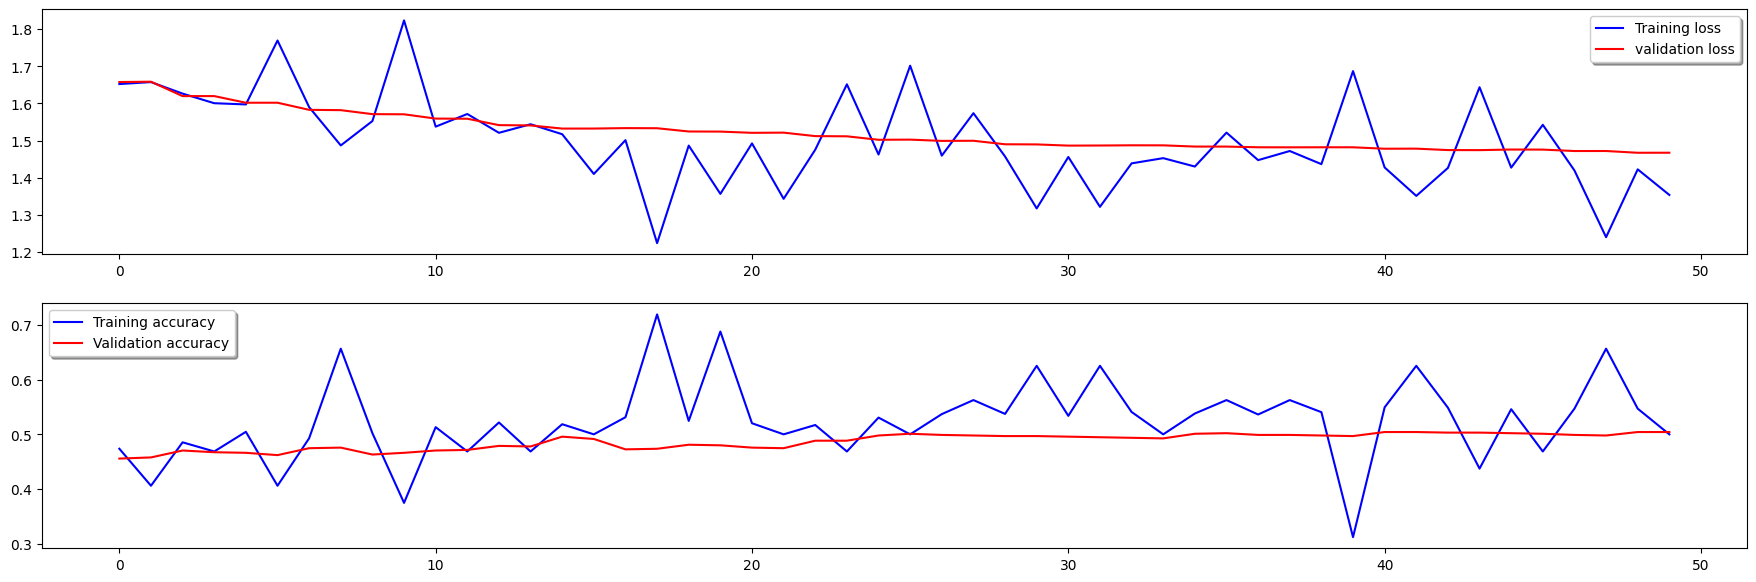

In [210]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


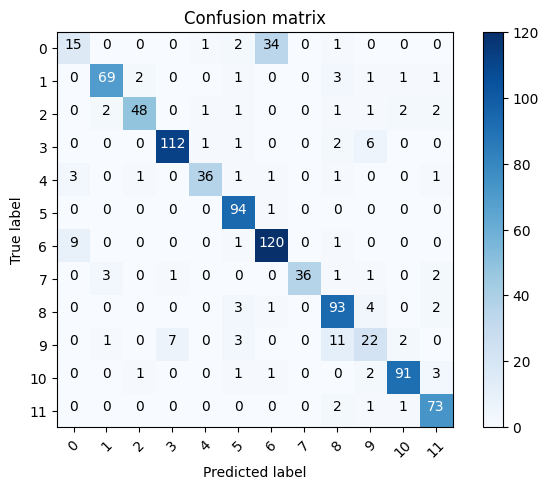

In [217]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(12))

**Observations**

Overall, we're getting a decent performance from the test set at 83%. However, we're getting a decently sized mix-up from the `0` and `6` labels, as show in the confusion matrix. 

## Final Model

In [213]:
print(results_df)

                    Model  Test Loss  Test Accuracy
0             Built Model   0.844651       0.747368
1                   VGG16   1.684227       0.465263
2  Built Model w Data Aug   0.575636       0.833684
3        VGG16 w Data Aug   1.497927       0.497895


We can see of the various models that were built, the one that performed the best was our Built Model with Data Augmentation. 

### Visualizing the prediction

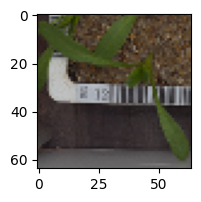

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Sugar beet']
True Label Sugar beet


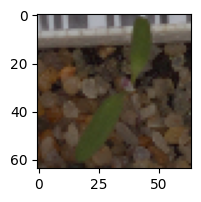

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Fat Hen']
True Label Fat Hen


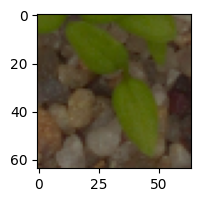

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


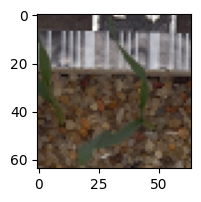

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Common wheat']
True Label Common wheat


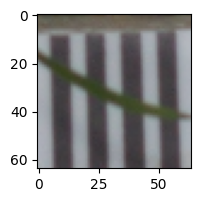

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Black-grass']
True Label Loose Silky-bent


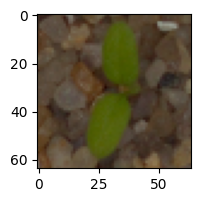

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


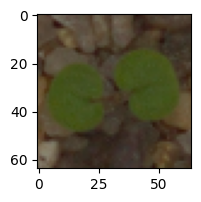

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


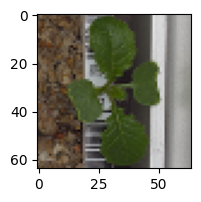

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Label ['Charlock']
True Label Charlock


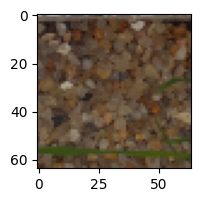

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


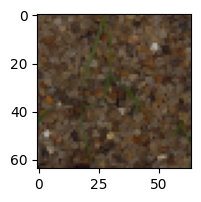

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


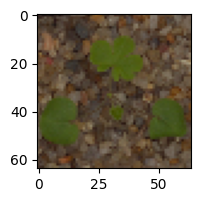

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


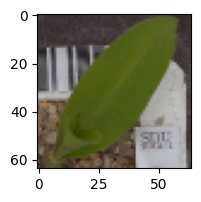

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Label ['Maize']
True Label Maize


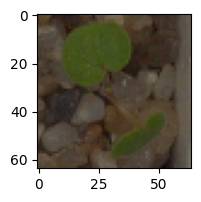

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


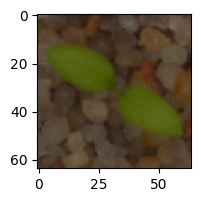

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


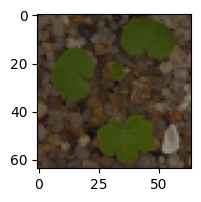

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


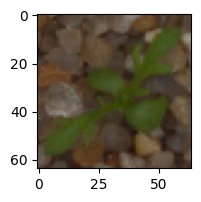

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Scentless Mayweed']
True Label Scentless Mayweed


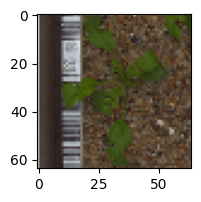

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Sugar beet']
True Label Shepherds Purse


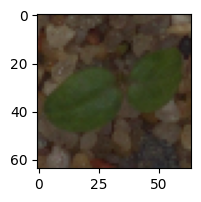

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Label ['Cleavers']
True Label Cleavers


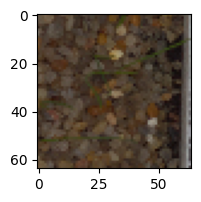

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


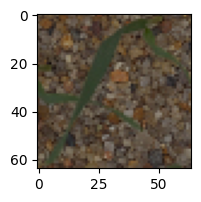

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Label ['Common wheat']
True Label Common wheat


In [239]:
# Select 10 random indices from the test data
random_indices = np.random.choice(len(X_test), size=20)

for i in random_indices:
    # Visualizing the predicted and correct label of images from test data
    plt.figure(figsize=(2,2))
    plt.imshow(X_test[i])
    plt.show()
    # Predict the test data using the final model selected
    print('Predicted Label', encoder.inverse_transform(model.predict((X_test[i].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
    print('True Label', encoder.inverse_transform(y_test)[i])

## Actionable Insights and Business Recommendations

The best model that was used was one that we built, and not leveraging any transfer learning from ImageNet models. However, the final model still yielded an 83% accuracy rate. Most of the error comes from a mixup between the plants `0`, and `6`. However, based on the random review of 20 images of the Test set, only 2 were incorrect. The model does appear to be reliable for plant seedling identification. 

For business recommendations and to further improve the model, I recommend the following:
* Increase the training dataset. A number of the images had nearly a third of the top images. It appears that the mixup occurred between a dataset with the least amount and the most amount. The model predicted the images incorrectly as a result. This imbalance should be improved.
* Further, we can grab some imagery with a better contrasting background, by using different colored soil or placing somethign underneath the plants. We can utilize filters to further create masks to contrast the layers of the image, however it would be preferential to do this when capturing the photo in the first place.
* we could further utilize ensemble methods to improve the model, such as decision trees in addition to the computer vision model. It may take additional time to build the model, but an increase in accuracy is important.
* Suggest deploying the model on a handheld device, such as a phone, so plants can be identified in the field. Additional work can be done to allow the model to run inference multiple times and provide an output based on highest probability in order to help further prevent misidentification.
* Alternatively, in order to identify multiple plants at once, a high resolution camera can be utilized and take imagery from a larger area, and then segmented amongst the different plant seedlings to be ran within this model. This will save time, and allow a number of identifications all at once.

_____